In [2]:
from _HyperSBM import *
from _HyperCommunityDetection import *
from _SBMMatrix import *
from _FigureJiazeHelper import *
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
from scipy.sparse.linalg import eigs, eigsh
from scipy.linalg import eig
from _CommunityDetect import *
from spectralOperator import BetheHessian
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

 No module named 'igraph'. If you need to use hypernetx.algorithms.hypergraph_modularity, please install additional packages by running the following command: pip install .['all']


In [3]:
# Matplotlib settings

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=16)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['lines.markersize'] = 12

%config InlineBackend.figure_format = 'retina'

# Spectrum of NB BH for SBM

pin=0.07142857142857142, pout=0.014285714285714285


D:\BackProgram\Anaconda\envs\network\Lib\site-packages\matplotlib_inline\config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


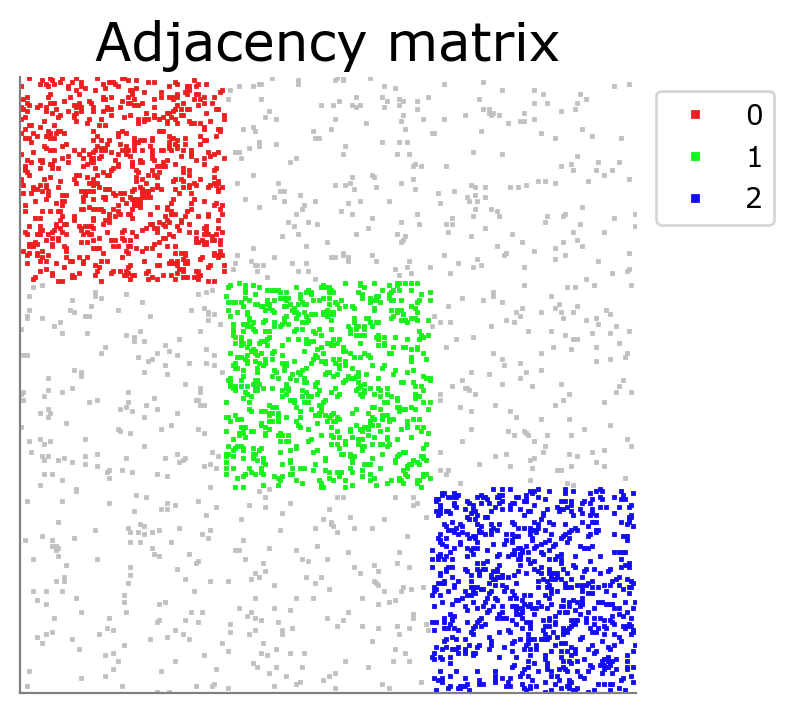

In [4]:
# Symmetric
n = 300
k = 3
d = 10
epsilon = 0.2
net = SymmetricSBM.init_epsc(n, k, d, epsilon)

fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(net.sizes))
plot_block_matrix(net.A.toarray(), partition_names=list(range(len(net.sizes))), partition_counts=net.sizes, colors=c)

In [9]:
def scatter_spectral(eigvalue, fig=None, ax=None, title='Spectrum', title_x=0.25):
    # Construct scatter coordinate
    x = []
    y = []
    for _w in eigvalue:
        _x = _w.real if isinstance(_w, complex) else _w
        _y = _w.imag if isinstance(_w, complex) else 0
        x.append(_x)
        y.append(_y)
    if fig is None and ax is None:
        fig = plt.figure(figsize=(8, 8))
        widths = [4]
        heights = [4]
        spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
        row = 0
        col = 0
        ax = fig.add_subplot(spec5[row, col])
    ax.set_aspect('equal',adjustable='box')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
#     ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data', 0))
#     ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.scatter(x, y, s=6)
    ax.set_title(title, x=title_x, y=1.07)

In [33]:
def plot_spectral_NBBH(sbm, bulk, extend_vline=2.65, eig_B=None, ylabel_coor1=(0.25,0.95), ylabel_coor2=(0.2,0.95), 
                       title_x=0.25, eigBH_amplify=1, xlabel_x=1.02):
#     print(f'SNR={sbm.get_SNR()}, d={d}')
    if eig_B is None:
        NB = sbm.get_operator('NB')
        print(np.shape(NB))
        eig_B, _ = eig(NB.toarray())
    info_eig = []
#     bulk = np.sqrt(d)
    for e in eig_B:
        if abs(e) > bulk and e.imag == 0:
            info_eig.append(e)
    print(info_eig)
    fig = plt.figure(figsize=(8, 8))
    widths = [5]
    heights = [5, 5]
    spec5 = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights)
    row = 0
    col = 0
    ax = fig.add_subplot(spec5[row, col])
    scatter_spectral(eig_B, fig=fig, ax=ax, title=r"Spectrum of $\mathrm{NB}$", title_x=title_x)
    ax.add_patch(Circle(xy = (0.0, 0.0), radius=bulk, alpha=0.2))
    ax.set_ylim(-bulk-1, 1 * bulk + 1)
    ax.set_xlim(-bulk-1, max(info_eig).real+1)
    left, right = ax.get_xlim()
    for e in info_eig:
        ax.axvline(e.real, c='black', ls=':', lw=1)
    ax.axvline(bulk, c='black', ls='-', lw=1)
    ax.set_xlabel('real', loc='right', size=15)
    ax.set_ylabel('imag', loc='top', size=15)
    ax.yaxis.set_label_coords(ylabel_coor1[0],ylabel_coor1[1])
    ax.xaxis.set_label_coords(xlabel_x, 0.4)
    y_locs, y_ticks = plt.yticks()
    x_locs, x_ticks = plt.xticks()
    ax.apply_aspect()
    
    row = 1
    col = 0
    ax = fig.add_subplot(spec5[row, col])
    bh_samples = 40
    c = gen_colors(start=colors_red[0], end=colors_green[0], n=bh_samples)
    i = 0
    eig_BHs = dict()
    eig_max = 0
    for r in np.linspace(bulk, max(info_eig).real+1, bh_samples):
        BH = sbm.get_operator('BH', r=r)
        eig_BH, _ = eig(BH.toarray())
        eig_BHs[r] = eig_BH
        eig_max = max(eig_BH) if max(eig_BH) > eig_max else eig_max
#     eig_max = max(eig_BHs[max(info_eig).real+1])
    for r in np.linspace(bulk, max(info_eig).real+1, bh_samples):
        eig_BH = eig_BHs[r]
        x = []
        y = []
        for _w in eig_BH:
            _y = _w.real if isinstance(_w, complex) else _w
            _y = _y / eig_max * (bulk + 1) * eigBH_amplify # normalize
            x.append(r)
            y.append(_y)
        ax.scatter(x, y, s=2, c=c[i])
        i += 1
    ax.set_aspect('equal',adjustable='box')
    ax.set_title(r"Spectrum of $\mathrm{BH_\lambda}$", x=title_x, y=1.07)
    ax.set_xlabel(r'$\lambda$', loc='right', size=15)
    ax.set_ylabel('eigenvalue', loc='top', size=15)
    ax.yaxis.set_label_coords(ylabel_coor2[0],ylabel_coor2[1])
    ax.xaxis.set_label_coords(1, 0.4)
    ax.set_yticks(y_locs, y_ticks)
    ax.set_xticks(x_locs, x_ticks)
    ax.set_ylim(-bulk-1, 1 * bulk + 1)
#     ax.set_xlim(-bulk-1, max(info_eig).real+1)
    ax.set_xlim(left, right)
    for e in info_eig:
        ax.vlines(e.real, ymin=-bulk-1, ymax=bulk+extend_vline, colors='black', linestyles=':', linewidths=1, clip_on=False)
    ax.vlines(bulk, ymin=-bulk-1, ymax=bulk+extend_vline, colors='black', linestyles='-', linewidths=1, clip_on=False)
    ax.spines['left'].set_position(('data', 0.0))
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.spines['top'].set_color('none')
    ax.apply_aspect()
#     x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9  # subregion of the original image
#     axins = ax.inset_axes(
#         [0.5, 0.5, 0.47, 0.47],
#         xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
#     axins.imshow(Z2, extent=extent, origin="lower")

#     ax.indicate_inset_zoom(axins, edgecolor="black")
#     BH = sbm.get_operator('BH', r=np.sqrt(d))
#     eig_BH, _ = eig(BH.toarray())
#     info_eig = []
#     for e in eig_BH:
#         if e < 0:
#             info_eig.append(e)
#     print(info_eig)
#     row = 0
#     col = 1
#     ax = fig.add_subplot(spec5[row, col])
#     scatter_spectral(eig_BH, fig=fig, ax=ax, title="Spectrum of BH with pos r")
    
#     BH = sbm.get_operator('BH', r=-np.sqrt(d))
#     eig_BH, _ = eig(BH.toarray())
#     info_eig = []
#     for e in eig_BH:
#         if e < 0:
#             info_eig.append(e)
#     print(info_eig)
#     row = 1
#     col = 1
#     ax = fig.add_subplot(spec5[row, col])
#     scatter_spectral(eig_BH, fig=fig, ax=ax, title="Spectrum of BH with neg r")

(3074, 3074)
[(10.07293731754191+0j), (6.266853732930123+0j), (5.822349450559597+0j)]


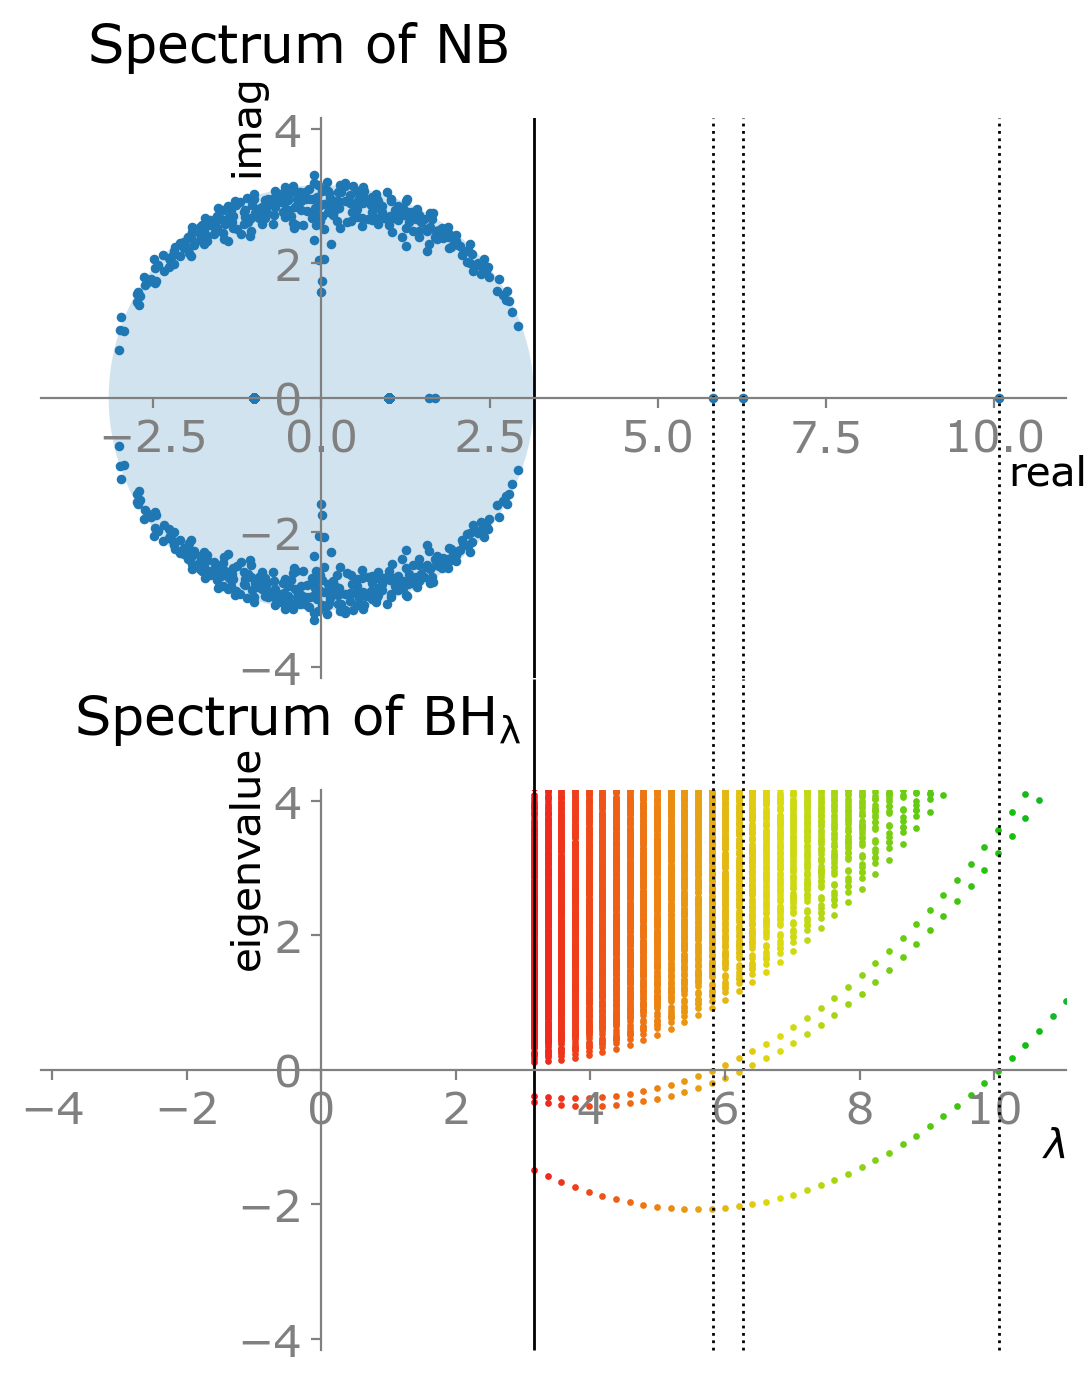

In [23]:
plot_spectral_NBBH(net, bulk=np.sqrt(d), ylabel_coor1=(0.22, 1.08), ylabel_coor2=(0.22, 1.08), eigBH_amplify=5)
save_path = "./_Figure/Hyper/" + "FigureNBBHspectrum_SBM_v1.pdf"
# plt.tight_layout()
plt.savefig(save_path, dpi=600)

# Spectrum of NB BH for uniformHSBM

Generating hyper edges for order 3...


161700it [00:04, 36186.23it/s]


# of nodes 100, # of edges 100


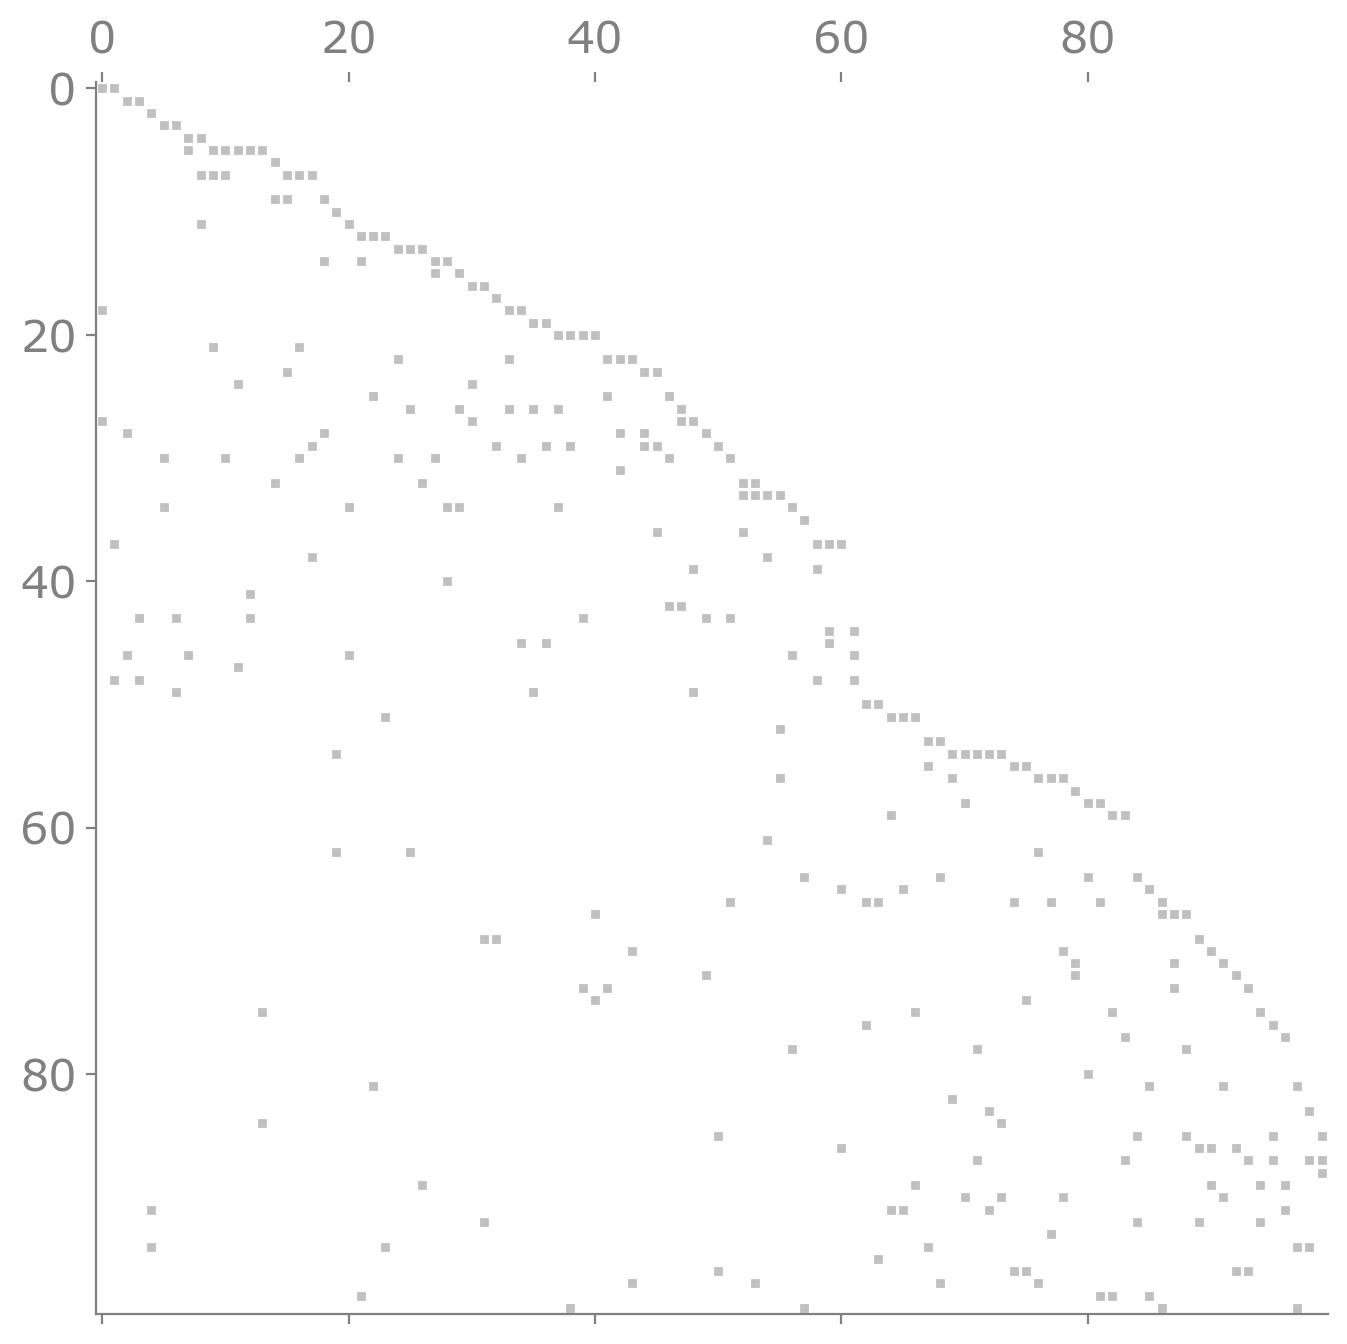

In [24]:
n = 100
q = 2
k = 3
cin = 20
cout = 2
hsbm = UniformSymmetricHSBM(n, q, k, cin, cout)
print(f'# of nodes {hsbm.n}, # of edges {hsbm.e}')
fig = plt.figure(figsize=(8, 8))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
plt.spy(hsbm.H, markersize=2, rasterized=True, color=gray)

In [25]:
NB = hsbm.get_operator('NB')
print(np.shape(NB))
eig_NB, eigv_NB = eig(NB.toarray())

Non-backtrack constructing for 300 directed node-hyperEdge pairs...


90000it [00:54, 1637.97it/s]


(300, 300)


[(5.768070300537108+0j), (3.795254758182156+0j)]


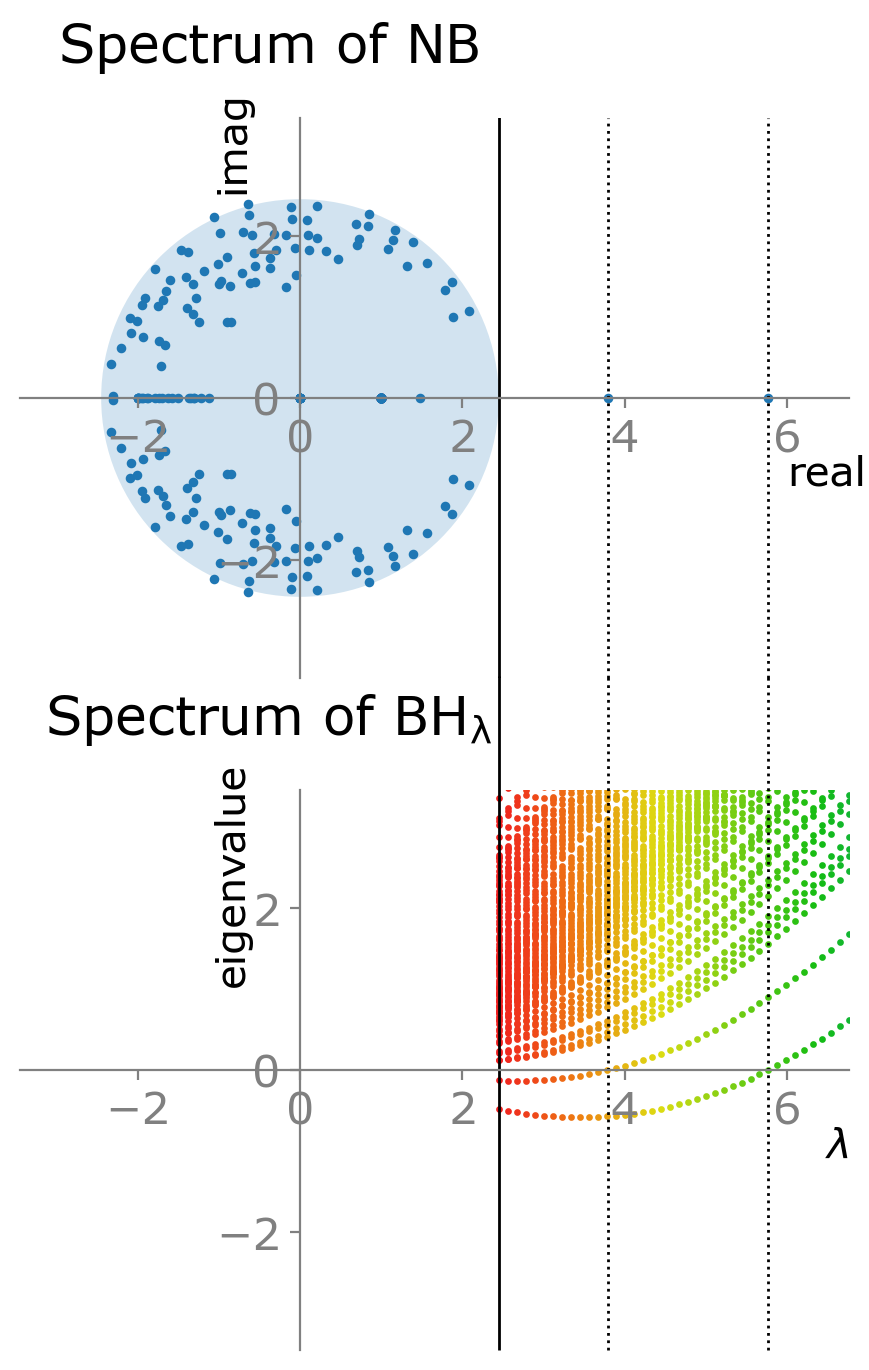

In [28]:
d = hsbm.H.sum() / hsbm.n
bulk = np.sqrt(d * (k - 1))
plot_spectral_NBBH(hsbm, bulk, extend_vline=2.4, eig_B=eig_NB, ylabel_coor1=(0.28, 1.05), ylabel_coor2=(0.28, 1.05),
                   title_x=0.3, eigBH_amplify=3)
save_path = "./_Figure/Hyper/" + "NBBHspectrum_uniformHSBM_v1.pdf"
# plt.tight_layout()
plt.savefig(save_path, dpi=600)

# Spectrum of NB BH for NonuniformHSBM

Generating hyper edges for order 2...


4950it [00:00, 34969.31it/s]


Generating hyper edges for order 3...


161700it [00:04, 34896.81it/s]


Generating hyper edges for order 4...


3921225it [01:53, 34588.04it/s]


# of nodes 100, # of edges 655


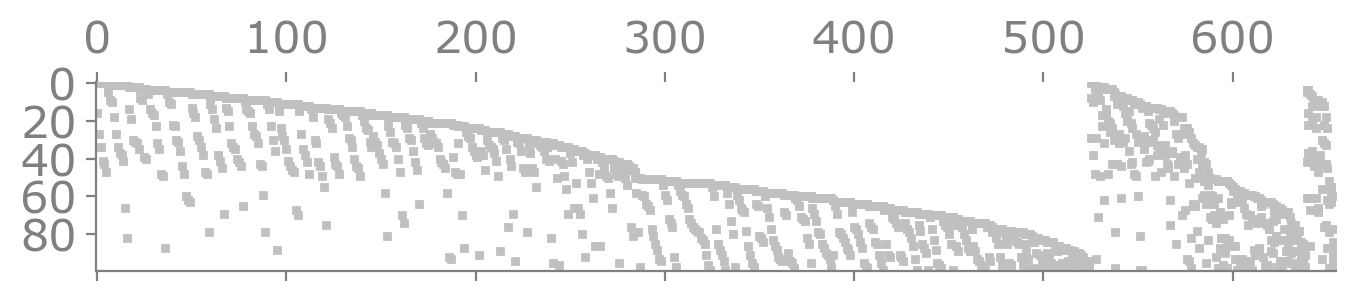

In [29]:
n = 100
q = 2
Ks = [2, 3, 4]
cin = 20
cout = 2
hsbm = UnUniformSymmetricHSBM(n, q, Ks, cin, cout)
print(f'# of nodes {hsbm.n}, # of edges {hsbm.e}')
fig = plt.figure(figsize=(8, 8))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
plt.spy(hsbm.H, markersize=2, rasterized=True, color=gray)

In [30]:
d = hsbm.H.sum() / hsbm.n
print(f'HyperGraph, d={d}')
NB = hsbm.get_operator('NB')
print(np.shape(NB))
eig_NB, eigv_NB = eig(NB.toarray())
info_eig = []
for e in eig_NB:
    if abs(e) > np.sqrt(d) and e.imag == 0:
        info_eig.append(e)
print(info_eig)

HyperGraph, d=14.56
Non-backtrack constructing for 1456 directed node-hyperEdge pairs...


2119936it [21:49, 1618.97it/s]


(1456, 1456)
[(19.370816695633415+0j), (14.022959626096602+0j)]


In [31]:
edge_order, edge_count = np.unique(hsbm.H.sum(axis=0).flatten(), return_counts=True)
order_count = dict(zip(edge_order, edge_count))
print(order_count)
ds = dict()
for o in order_count:
    ds[o] = o * order_count[o] / n
bulk = 0
for k in Ks:
    bulk += ds[k] * (k - 1)
bulk = np.sqrt(bulk)

{2: 525, 3: 114, 4: 16}


[(19.370816695633415+0j), (14.022959626096602+0j)]


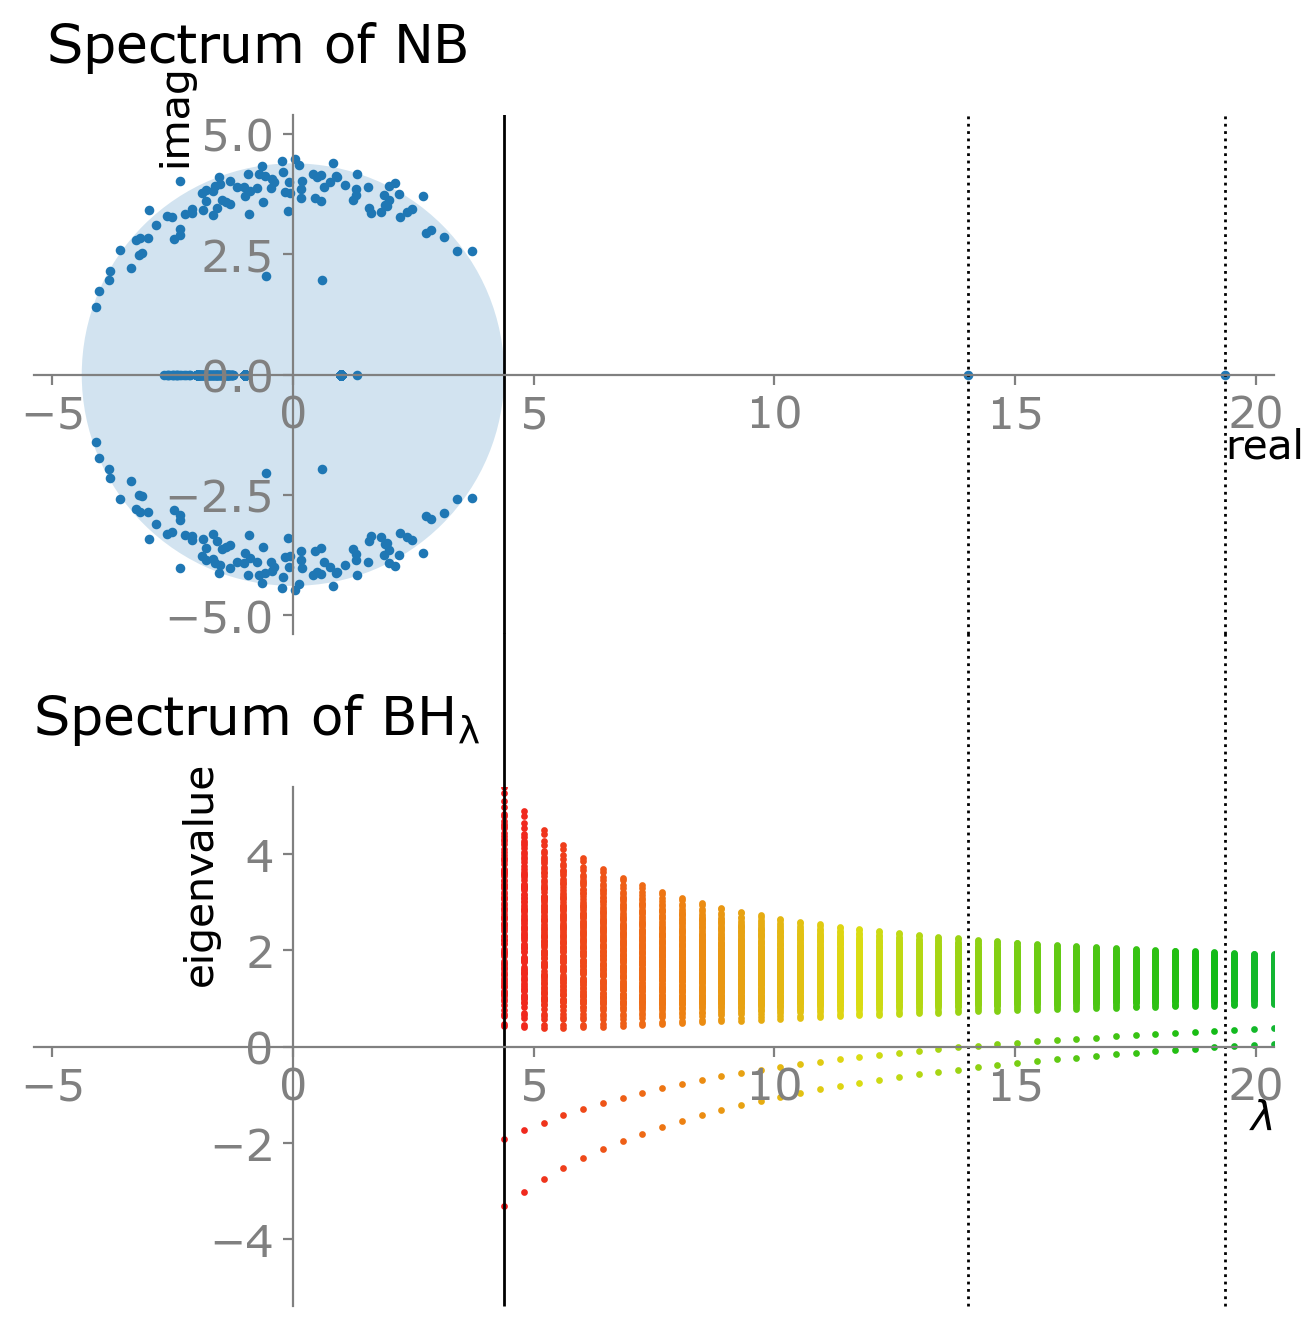

In [45]:
plot_spectral_NBBH(hsbm, bulk, extend_vline=4.2, eig_B=eig_NB, ylabel_coor1=(0.13, 1.1), ylabel_coor2=(0.15, 1.05), 
                   title_x=0.18, xlabel_x=1.025)
save_path = "./_Figure/Hyper/" + "NBBHspectrum_NonuniformHSBM_v1.pdf"
plt.savefig(save_path, dpi=600)

# Visulization hyper graph

Generating hyper edges for order 3...


120it [00:00, 20168.96it/s]


Generating hyper edges for order 4...


210it [00:00, 20095.91it/s]

# of nodes 10, # of edges 12


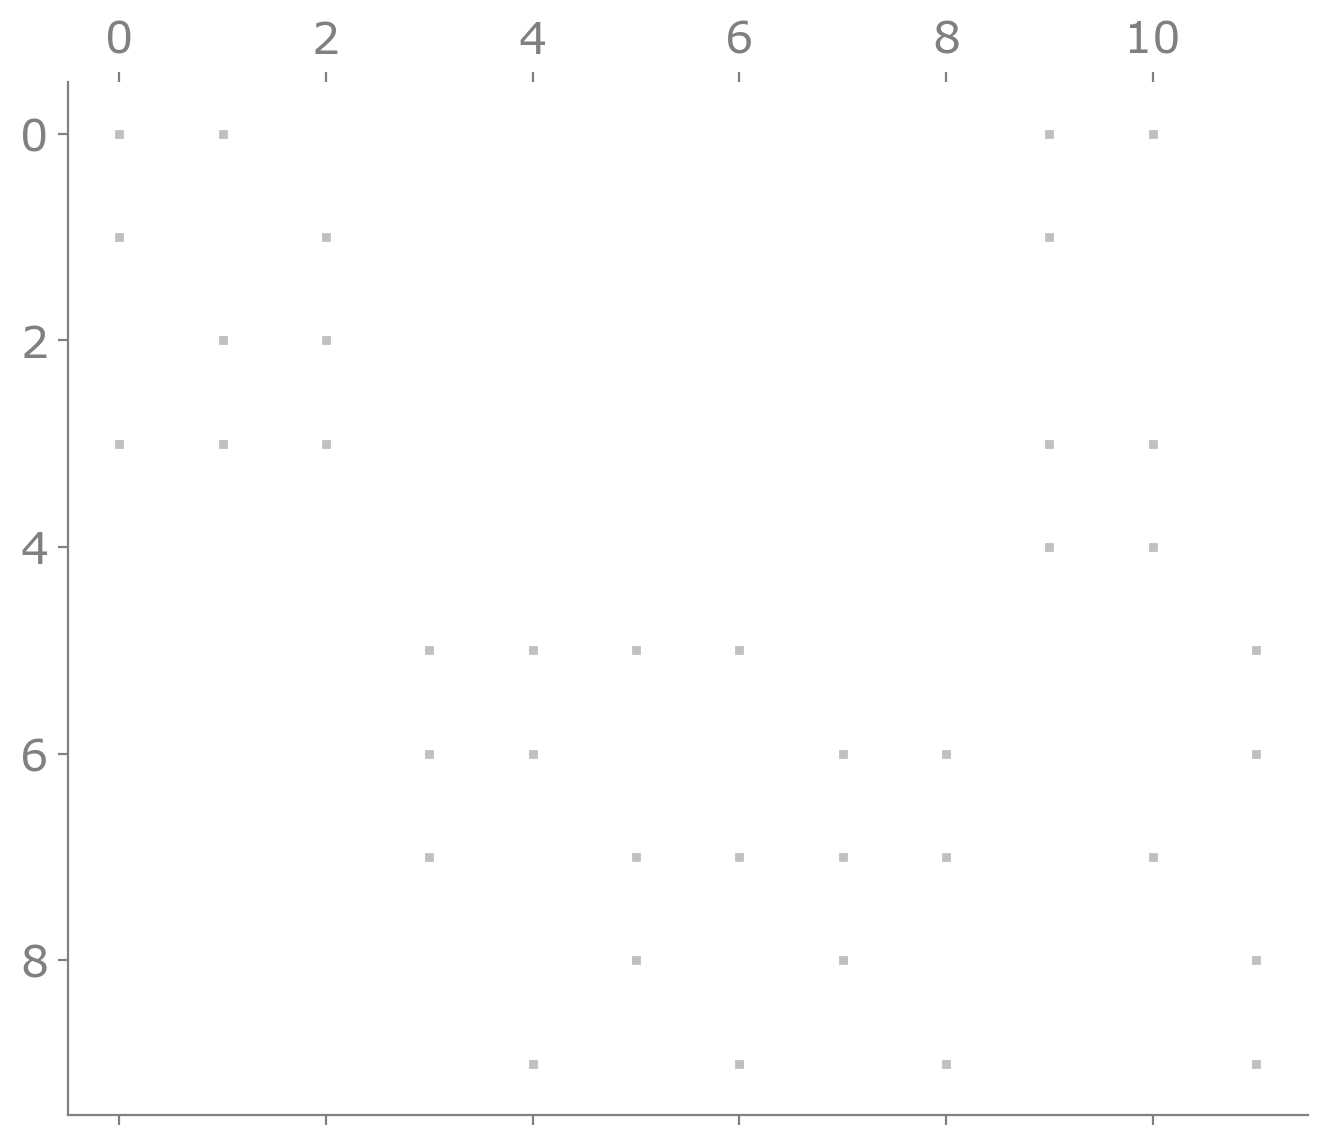

In [166]:
n = 10
q = 2
Ks = [3, 4]
cin = 40
cout = 2
hsbm = UnUniformSymmetricHSBM(n, q, Ks, cin, cout)
print(f'# of nodes {hsbm.n}, # of edges {hsbm.e}')
fig = plt.figure(figsize=(8, 8))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
plt.spy(hsbm.H, markersize=2, rasterized=True, color=gray)

[3 3 4 4 3 3 3 3 4]
8
9
2
6
3
7
5
1
4
0


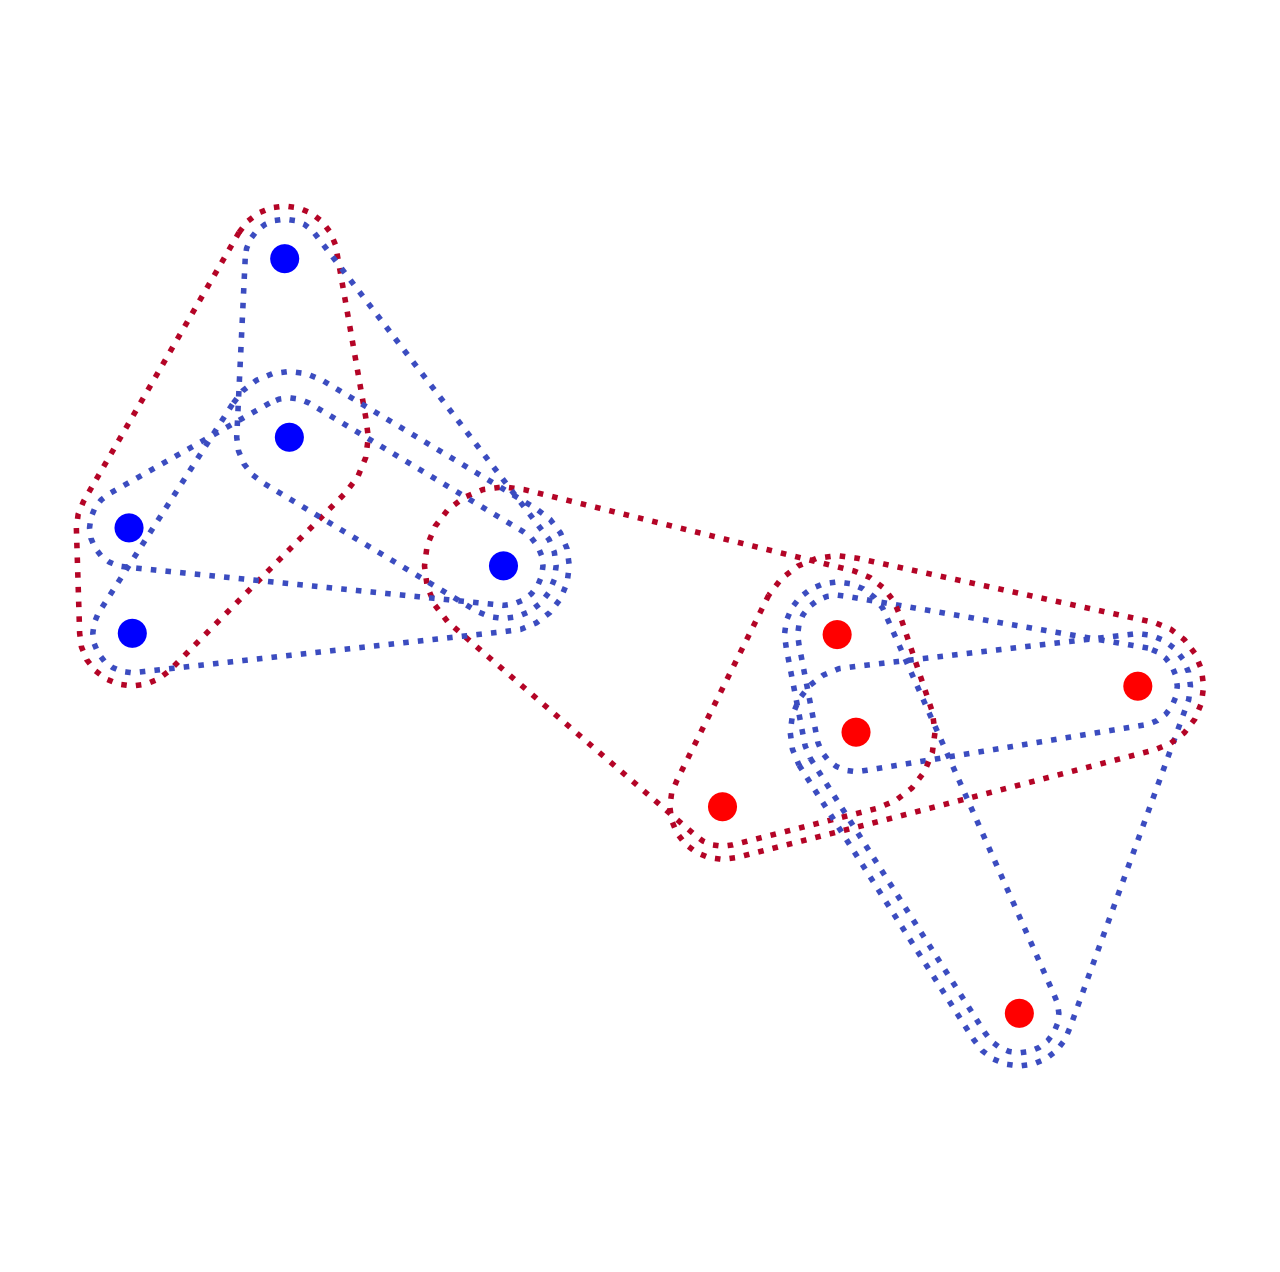

In [186]:
# hsbm.hyper_g.add_edges([(1, 'v7'), (1, 'v0'),(1, 'v3')])
hsbm.hyper_g = hsbm.hyper_g.remove_edges(['e4', 'e5', 'e6'])
sizes = np.array([hsbm.hyper_g.size(e) for e in hsbm.hyper_g.edges()])
print(sizes)
linestyles = [':' if s==3 else '_'for s in sizes]
cmap = plt.cm.coolwarm
norm = plt.Normalize(sizes.min(), sizes.max())

alpha = 1
def get_node_color(v):
    print(v.split('v')[1])
    if int(v.split('v')[1]) < 5:
        return "red"
    else:
        return "blue"

fig = plt.figure(figsize=(8, 8))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
hnx.drawing.draw(hsbm.hyper_g, with_edge_labels=False, with_node_labels=False, layout=nx.kamada_kawai_layout, 
                 edges_kwargs={
                     'edgecolors': cmap(norm(sizes))*(1, 1, 1, alpha),
                     'linewidths': 2,
                     'linestyles': ':'
                 }, nodes_kwargs={
                     'color': get_node_color
                 })
save_path = "./_Figure/Hyper/" + "SampleHyperGraph.pdf"
plt.savefig(save_path, dpi=600)

In [214]:
hsbm.H = csr_array(hsbm.hyper_g.incidence_matrix())
hsbm.H.toarray()
hsbm.e = 9

In [190]:
d = hsbm.H.sum() / hsbm.n
print(f'HyperGraph, d={d}')
NB = hsbm.get_operator('NB')
print(np.shape(NB))
eig_NB, eigv_NB = eig(NB.toarray())
info_eig = []
for e in eig_NB:
    if abs(e) > np.sqrt(d) and e.imag == 0:
        info_eig.append(e)
print(info_eig)

HyperGraph, d=3.0
Non-backtrack constructing for 30 directed node-hyperEdge pairs...


900it [00:00, 1592.56it/s]

(30, 30)
[(5.631200152601493+0j), (3.3052532711416336+0j), (-3.1268632529244207+0j)]


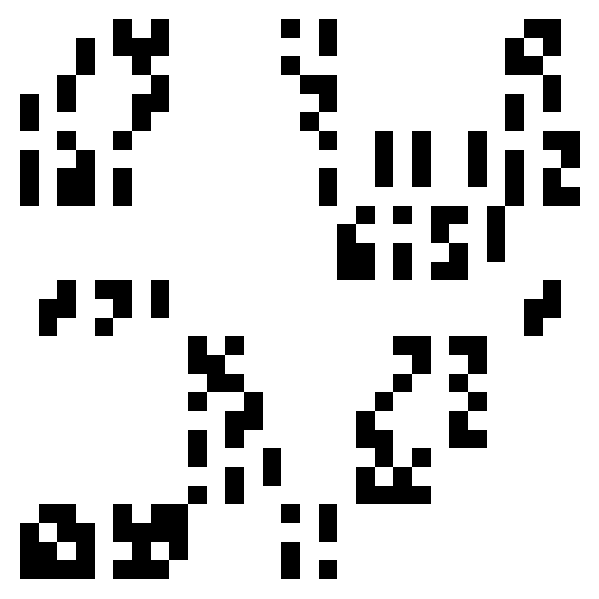

In [219]:
fig = plt.figure(figsize=(8, 8))
widths = [5]
heights = [5, 5]
spec5 = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
ax.set_aspect('equal')
ax.set_axis_off()
ax.imshow(NB.toarray(), cmap='Greys')
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.set_xticks([])
ax.set_yticks([])
save_path = "./_Figure/Hyper/" + "SampleNonbacktrackingMatrix.pdf"
plt.savefig(save_path, dpi=600)

In [215]:
edge_order, edge_count = np.unique(hsbm.H.sum(axis=0).flatten(), return_counts=True)
order_count = dict(zip(edge_order, edge_count))
print(order_count)
ds = dict()
for o in order_count:
    ds[o] = o * order_count[o] / n
bulk = 0
for k in Ks:
    bulk += ds[k] * (k - 1)
bulk = np.sqrt(bulk)

{3: 6, 4: 3}


In [216]:
BH = hsbm.get_operator('BH', r=bulk)

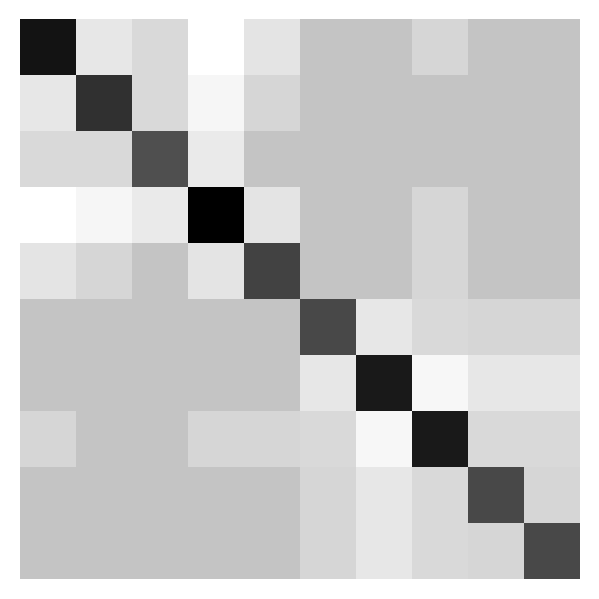

In [221]:
fig = plt.figure(figsize=(8, 8))
widths = [5]
heights = [5, 5]
spec5 = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
ax.set_axis_off()
ax.set_aspect('equal')
ax.imshow(BH.toarray(), cmap='Greys')
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.set_xticks([])
ax.set_yticks([])
save_path = "./_Figure/Hyper/" + "SampleBetheHessianMatrix.pdf"
plt.savefig(save_path, dpi=600)